In [13]:
import gc
import torch
import torch.nn as nn
from torch import Tensor
from typing import Tuple
from abc import ABC, abstractmethod

# =============================================================================
# Abstract Base Class: MonteCarloSampler
# =============================================================================
class MonteCarloSampler(nn.Module, ABC):
    r"""Abstract Monte Carlo sampler providing the skeleton for the sampling process.

    The class implements the general workflow:
      - forward(): Performs thermalization, production sampling, and parallel tempering exchanges.
      - one_sweep(): Executes a single sweep that updates both black and white sub-lattices.
      - parallel_tempering_exchange(): Attempts exchanges between adjacent temperature chains.
      - _prepare_checkerboard_indices(): Precomputes the checkerboard indices and their neighbors.

    Subclasses must implement the following abstract methods:
      1. init_spins(): Initialize the spin configuration (e.g., angles for XY, ±1 for Ising).
      2. metropolis_update_sub_lattice(): Perform Metropolis updates on a given sub-lattice.
      3. compute_energy(): Compute the energy tensor of the entire system.
    """

    def __init__(self,
                 L: int,
                 T: Tensor,
                 n_chains: int = 30,
                 J: float = 1.0,
                 device: torch.device = torch.device("cpu"),
                 use_amp: bool = False,
                 large_size_simulate: bool = False,
                 pt_enabled: bool = True) -> None:
        """
        Args:
            L (int): Linear size of the lattice.
            T (Tensor): Temperature tensor; its batch dimension sets the number of samples.
            n_chains (int, optional): Number of Monte Carlo chains per temperature. Defaults to 1.
            J (float, optional): Coupling constant. Defaults to 1.0.
            device (torch.device, optional): Device on which to perform computations. Defaults to CPU.
            use_amp (bool, optional): Flag to enable automatic mixed precision. Defaults to False.
            large_size_simulate (bool, optional): Flag for large-scale simulation (move samples to CPU). Defaults to False.
            pt_enabled (bool, optional): Flag to enable parallel tempering exchanges. Defaults to True.
        """
        super().__init__()
        self.L = L
        self.T = T.to(device)
        self.batch_size = self.T.shape[0]
        self.n_chains = n_chains
        self.J = J
        self.device = device
        self.use_amp = use_amp
        self.large_size_simulate = large_size_simulate
        self.pt_enabled = pt_enabled

        # Pre-register a zero tensor for future comparisons
        self.register_buffer('zero', torch.tensor(0, device=device))

        # Initialize the spin configuration; implementation is deferred to subclasses.
        self.init_spins()

        # Precompute the checkerboard indices and neighbor coordinates for sub-lattice updates.
        self._prepare_checkerboard_indices()

    @abstractmethod
    def init_spins(self) -> None:
        r"""Initialize the spin configuration.

        This method must be implemented by subclasses.
        For example:
          - XY model: angles ∈ [0, 2π)
          - Ising model: spins ∈ {+1, -1}
        """
        pass

    @abstractmethod
    def metropolis_update_sub_lattice(self, lattice_color: str, adaptive: bool = False) -> None:
        r"""Perform the Metropolis update on the specified sub-lattice.

        Args:
            lattice_color (str): Indicates which sub-lattice to update ('black' or 'white').
            adaptive (bool, optional): Flag for adaptive update parameters. Defaults to False.
        """
        pass

    @abstractmethod
    def compute_energy(self) -> Tensor:
        r"""Compute the energy of the system.

        Returns:
            Tensor: Energy tensor with shape [batch_size, n_chains].
        """
        pass

    def _prepare_checkerboard_indices(self) -> None:
        r"""Prepare checkerboard (black/white) indices and their four periodic neighbors.

        This method precomputes the indices for black and white sub-lattices as well as the corresponding
        neighbor coordinates (up, down, left, right) with periodic boundary conditions.
        The indices are broadcasted to shape [batch_size, n_chains, N_sites] for use in sub-lattice updates.
        """
        L = self.L
        i_coords = torch.arange(L, device=self.device)
        j_coords = torch.arange(L, device=self.device)
        grid_i, grid_j = torch.meshgrid(i_coords, j_coords, indexing='ij')

        # Create a checkerboard pattern: black sites where (i + j) is even; white sites otherwise.
        black_mask = ((grid_i + grid_j) % 2 == 0)
        white_mask = ~black_mask

        black_indices = torch.nonzero(black_mask, as_tuple=False).to(self.device)
        white_indices = torch.nonzero(white_mask, as_tuple=False).to(self.device)
        self.num_black = black_indices.shape[0]
        self.num_white = white_indices.shape[0]

        B, C = self.batch_size, self.n_chains
        batch_idx = torch.arange(B, device=self.device).view(B, 1, 1)
        chain_idx = torch.arange(C, device=self.device).view(1, C, 1)

        # Expand indices for black sites.
        black_i = black_indices[:, 0].view(1, 1, self.num_black).expand(B, C, self.num_black)
        black_j = black_indices[:, 1].view(1, 1, self.num_black).expand(B, C, self.num_black)

        # Expand indices for white sites.
        white_i = white_indices[:, 0].view(1, 1, self.num_white).expand(B, C, self.num_white)
        white_j = white_indices[:, 1].view(1, 1, self.num_white).expand(B, C, self.num_white)

        self.register_buffer('black_batch_idx', batch_idx.expand(B, C, self.num_black))
        self.register_buffer('black_chain_idx', chain_idx.expand(B, C, self.num_black))
        self.register_buffer('black_i_sites', black_i)
        self.register_buffer('black_j_sites', black_j)

        self.register_buffer('white_batch_idx', batch_idx.expand(B, C, self.num_white))
        self.register_buffer('white_chain_idx', chain_idx.expand(B, C, self.num_white))
        self.register_buffer('white_i_sites', white_i)
        self.register_buffer('white_j_sites', white_j)

        # Compute neighbors for both black and white sites.
        black_neighbors_i, black_neighbors_j = self._compute_neighbors(black_indices)
        white_neighbors_i, white_neighbors_j = self._compute_neighbors(white_indices)

        # Reshape and expand neighbor indices.
        black_neighbors_i = black_neighbors_i.view(1, 1, self.num_black, 4).expand(B, C, self.num_black, 4)
        black_neighbors_j = black_neighbors_j.view(1, 1, self.num_black, 4).expand(B, C, self.num_black, 4)
        white_neighbors_i = white_neighbors_i.view(1, 1, self.num_white, 4).expand(B, C, self.num_white, 4)
        white_neighbors_j = white_neighbors_j.view(1, 1, self.num_white, 4).expand(B, C, self.num_white, 4)

        self.register_buffer('black_neighbors_i', black_neighbors_i)
        self.register_buffer('black_neighbors_j', black_neighbors_j)
        self.register_buffer('white_neighbors_i', white_neighbors_i)
        self.register_buffer('white_neighbors_j', white_neighbors_j)

        # Clean up intermediate variables and force garbage collection.
        del (black_neighbors_i, black_neighbors_j, white_neighbors_i, white_neighbors_j,
             black_indices, white_indices, batch_idx, chain_idx,
             grid_i, grid_j, i_coords, j_coords, black_mask, white_mask)
        gc.collect()

    def _compute_neighbors(self, indices_2d: Tensor) -> Tuple[Tensor, Tensor]:
        r"""Compute the four periodic neighbors for given 2D indices.

        The neighbors are determined by periodic boundary conditions:
            - Up:    (i-1, j)
            - Down:  (i+1, j)
            - Left:  (i, j-1)
            - Right: (i, j+1)

        Args:
            indices_2d (Tensor): Tensor of shape [N, 2] containing the (i, j) coordinates.

        Returns:
            Tuple[Tensor, Tensor]: Two tensors containing the neighbor indices along the first and second axes, each of shape [N, 4].
        """
        L = self.L
        i_sites = indices_2d[:, 0]
        j_sites = indices_2d[:, 1]

        up_i = (i_sites - 1) % L
        up_j = j_sites
        down_i = (i_sites + 1) % L
        down_j = j_sites
        left_i = i_sites
        left_j = (j_sites - 1) % L
        right_i = i_sites
        right_j = (j_sites + 1) % L

        neighbors_i = torch.stack([up_i, down_i, left_i, right_i], dim=1)
        neighbors_j = torch.stack([up_j, down_j, left_j, right_j], dim=1)

        del i_sites, j_sites, up_i, up_j, down_i, down_j, left_i, left_j, right_i, right_j
        return neighbors_i, neighbors_j

    def set_parallel_tempering(self, enabled: bool) -> None:
        """Enable or disable parallel tempering exchanges.

        Args:
            enabled (bool): If True, parallel tempering is enabled.
        """
        self.pt_enabled = enabled

    def forward(self,
                n_sweeps: int = 1000,
                n_therm: int = 10000,
                decorrelate: int = 10,
                pt_interval: int = 10) -> Tensor:
        r"""Execute the main Monte Carlo sampling process.

        The process includes:
          1. Thermalization: n_therm sweeps.
          2. Production sampling: n_sweeps sweeps (samples recorded every 'decorrelate' steps).
          3. (Optional) Parallel tempering exchange.

        Args:
            n_sweeps (int, optional): Number of production sweeps. Defaults to 5000.
            n_therm (int, optional): Number of thermalization sweeps. Defaults to 2000.
            decorrelate (int, optional): Interval between recorded samples. Defaults to 100.
            pt_interval (int, optional): Frequency of parallel tempering exchanges during production. Defaults to 10.

        Returns:
            Tensor: Collected samples with shape [batch_size, n_chains×num_samples, L, L].
        """
        T = self.T.to(self.device)
        assert T.shape[0] == self.batch_size, "The batch dimension of T must match batch_size."
        sample_list = []

        with torch.autocast(device_type=self.device.type,
                              enabled=(self.device.type in ["cuda", "cpu"] and self.use_amp)):
            with torch.no_grad():
                # Thermalization phase
                for sweep in range(n_therm):
                    self.one_sweep()
                    if self.pt_enabled and (sweep % pt_interval == 0):
                        self.parallel_tempering_exchange()
                    if sweep % 1000 == 0:
                        gc.collect(generation=0)

                gc.collect(generation=1)

                # Production sampling phase
                for sweep in range(n_sweeps):
                    self.one_sweep()
                    if self.pt_enabled and (sweep % pt_interval == 0):
                        self.parallel_tempering_exchange()
                    if sweep % 1000 == 0:
                        gc.collect(generation=0)

                    if sweep % decorrelate == 0:
                        # For large simulations, move sample to CPU to mitigate GPU memory constraints.
                        if self.large_size_simulate:
                            sample_list.append(self.spins.clone().cpu())
                            torch.cuda.empty_cache()
                        else:
                            sample_list.append(self.spins.clone())

                # Stack and permute samples to shape [B, C, num_samples, L, L]
                samples = torch.stack(sample_list, dim=0)
                samples = samples.permute(1, 2, 0, 3, 4).contiguous()
                del sample_list
                gc.collect()

        return samples.view(self.batch_size, -1, self.L, self.L)

    def one_sweep(self, adaptive: bool = False) -> None:
        r"""Perform a single Monte Carlo sweep.

        The sweep consists of sequentially updating both the black and white sub-lattices.
        The specific update rule is implemented in the subclass via the metropolis_update_sub_lattice() method.

        Args:
            adaptive (bool, optional): If True, use adaptive update parameters. Defaults to False.
        """
        self.metropolis_update_sub_lattice('black', adaptive=adaptive)
        self.metropolis_update_sub_lattice('white', adaptive=adaptive)

    def parallel_tempering_exchange(self) -> None:
        r"""Perform parallel tempering exchange between adjacent temperature chains.

        The method exchanges configurations between neighboring batches based on the Metropolis criterion.
        It compares energies and temperature values to decide whether to swap spins.
        """
        T = self.T
        B, C, _, _ = self.spins.shape  # spins shape: [B, C, L, L]
        energies = self.compute_energy()  # shape: [B, C]
        T_b = T.view(B, 1).expand(B, C)
        idx = torch.arange(B, device=self.device)

        # Randomly select starting indices for exchange pairs.
        if torch.randint(0, 2, (1,), device=self.device) == self.zero:
            start_idx = idx[::2]
        else:
            start_idx = idx[1::2]
        start_idx = start_idx[start_idx < (B - 1)]
        partner_idx = start_idx + 1

        E_start = energies[start_idx, :]
        E_partner = energies[partner_idx, :]
        T_start = T_b[start_idx, :]
        T_partner = T_b[partner_idx, :]

        # Calculate acceptance probability for the swap.
        delta = (1.0 / T_start - 1.0 / T_partner) * (E_start - E_partner)
        prob = torch.exp(delta).clamp(max=1.0)
        rand_vals = torch.rand_like(prob)
        swap_mask = (rand_vals < prob)

        if swap_mask.any():
            # Swap spins between the paired configurations.
            spins_start = self.spins[start_idx, :, :, :].clone()
            spins_partner = self.spins[partner_idx, :, :, :].clone()
            tmp = spins_start.clone()
            spins_start[swap_mask] = spins_partner[swap_mask]
            spins_partner[swap_mask] = tmp[swap_mask]
            self.spins[start_idx, :, :, :] = spins_start
            self.spins[partner_idx, :, :, :] = spins_partner
            del tmp, spins_start, spins_partner

        # Clean up intermediate variables.
        del B, C, energies, T_b, idx, start_idx, partner_idx, E_start, E_partner, T_start, T_partner, delta, prob, rand_vals, swap_mask
        gc.collect(generation=0)

    @staticmethod
    def high_precision_derivative(
        seq: torch.Tensor,
        spacing: float = 1.0
    ) -> Tensor:
        """Compute first derivative of a 1D tensor with 4th-order central differences
        and 2nd-order forward/backward differences at boundaries.

        Uses in-place operations and vectorized slicing for performance.

        Args:
            seq (torch.Tensor): 1D tensor of function samples, shape (N,).
            spacing (float): Grid spacing h between samples. Defaults to 1.0.

        Returns:
            torch.Tensor: Tensor of shape (N,) with derivative approximations.

        Raises:
            ValueError: If `seq` is not 1D or length < 5.
        """
        if seq.ndim != 1:
            raise ValueError("Input tensor must be 1D.")
        N = seq.size(0)
        if N < 5:
            raise ValueError("Length of seq must be at least 5 for 4th-order accuracy.")
        # allocate output
        deriv = torch.empty_like(seq)

        # 4th-order central diff for interior points [2, N-3]
        # deriv[2:-2] = (-f[i+2] + 8f[i+1] - 8f[i-1] + f[i-2]) / (12h)
        deriv[2:-2].copy_(-seq[4:])                      # -f[i+2]
        deriv[2:-2].add_(seq[3:-1], alpha=8)             # +8 f[i+1]
        deriv[2:-2].add_(seq[1:-3], alpha=-8)            # -8 f[i-1]
        deriv[2:-2].add_(seq[0:-4])                      # + f[i-2]
        deriv[2:-2].div_(12 * spacing)                   # divide by 12h

        # 2nd-order forward difference at the left boundary
        deriv[0] = (-3 * seq[0] + 4 * seq[1] - seq[2]) / (2 * spacing)
        deriv[1] = (     seq[2] -     seq[0]) / (2 * spacing)

        # 2nd-order backward difference at the right boundary
        deriv[-2] = (     seq[-1] -     seq[-3]) / (2 * spacing)
        deriv[-1] = ( 3 * seq[-1] - 4 * seq[-2] + seq[-3]) / (2 * spacing)

        return deriv


In [14]:
import torch.nn.functional as F

# =============================================================================
# Subclass: XYModel
# =============================================================================
class XYModel(MonteCarloSampler):
    r"""Implementation of the 2D XY model (including the Berezinskii-Kosterlitz-Thouless transition).

    This class retains the full functionality and performance optimizations (in-place updates, vectorization)
    of the original BKTXYSampler, with added support for adaptive updates.
    """

    def __init__(self,
                 L: int,
                 T: Tensor,
                 n_chains: int = 30,
                 J: float = 1.0,
                 device: torch.device = torch.device("cpu"),
                 max_delta: float = torch.pi,
                 adaptive: bool = False,
                 target_acceptance: float = 0.6,
                 adapt_rate: float = 0.1,
                 adapt_interval: int = 5,
                 ema_alpha: float = 0.1,
                 use_amp: bool = True,
                 large_size_simulate: bool = False,
                 pt_enabled: bool = True) -> None:
        """
        Args:
            L (int): Lattice size.
            T (Tensor): Temperature tensor.
            n_chains (int, optional): Number of chains. Defaults to 30.
            J (float, optional): Coupling constant. Defaults to 1.0.
            device (torch.device, optional): Compute device. Defaults to CPU.
            max_delta (float, optional): Maximum angular perturbation. Defaults to π.
            adaptive (bool, optional): Flag to enable adaptive max_delta adjustments. Defaults to False.
            target_acceptance (float, optional): Target acceptance rate for adaptive updates. Defaults to 0.6.
            adapt_rate (float, optional): Adaptation rate. Defaults to 0.1.
            adapt_interval (int, optional): Number of sweeps between adaptations. Defaults to 5.
            ema_alpha (float, optional): Exponential moving average factor for the acceptance rate. Defaults to 0.1.
            use_amp (bool, optional): Enable automatic mixed precision. Defaults to True.
            large_size_simulate (bool, optional): Flag for large-scale simulation. Defaults to False.
            pt_enabled (bool, optional): Enable parallel tempering. Defaults to True.
        """
        super().__init__(
            L=L,
            T=T,
            n_chains=n_chains,
            J=J,
            device=device,
            use_amp=use_amp,
            large_size_simulate=large_size_simulate,
            pt_enabled=pt_enabled,
        )
        # XY-model specific parameters for adaptive updates.
        self.adaptive = adaptive
        self.target_acceptance = target_acceptance
        self.adapt_rate = adapt_rate
        self.adapt_interval = adapt_interval
        self.ema_alpha = ema_alpha

        # Register the maximum angular perturbation as a buffer.
        self.register_buffer('max_delta', torch.tensor(max_delta, device=device, dtype=torch.float32))
        # Initialize counters for acceptance statistics.
        self.register_buffer('accept_count', torch.tensor(0, dtype=torch.int64, device=self.device))
        self.register_buffer('total_trials', torch.tensor(0, dtype=torch.int64, device=self.device))
        self.sweep_count = 0
        # Initialize the exponential moving average of the acceptance rate.
        self.register_buffer('ema_accept_rate', torch.tensor(self.target_acceptance, device=self.device, dtype=torch.float32))

    def init_spins(self) -> None:
        r"""Initialize the spin configuration for the XY model.

        Spins are represented as angles ∈ [0, 2π). The tensor shape is [batch_size, n_chains, L, L].
        """
        theta_init = 2 * torch.pi * torch.rand(
            (self.batch_size, self.n_chains, self.L, self.L),
            dtype=torch.float32,
            device=self.device
        )
        self.spins = theta_init

    def one_sweep(self, adaptive: bool = False) -> None:
        r"""Perform one sweep and adjust max_delta if adaptive updates are enabled.

        Overrides the base class one_sweep to include adaptive adjustments.

        Args:
            adaptive (bool, optional): Whether to use adaptive update parameters. Defaults to False.
        """
        super().one_sweep(adaptive=self.adaptive)
        if self.adaptive:
            self.sweep_count += 1
            if self.sweep_count % self.adapt_interval == 0:
                self.adjust_max_delta()

    def metropolis_update_sub_lattice(self, lattice_color: str, adaptive: bool = False) -> None:
        r"""Perform a Metropolis update on the specified sub-lattice for the XY model.

        For each site in the sub-lattice, an angular perturbation is applied, the energy difference is computed,
        and the new angle is accepted or rejected according to the Metropolis criterion.

        Args:
            lattice_color (str): 'black' or 'white' indicating which sub-lattice to update.
            adaptive (bool, optional): Flag for using adaptive parameters. Defaults to False.
        """
        T = self.T

        # Select indices based on the chosen sub-lattice.
        if lattice_color == 'black':
            batch_idx = self.black_batch_idx
            chain_idx = self.black_chain_idx
            i_sites = self.black_i_sites
            j_sites = self.black_j_sites
            neighbors_i = self.black_neighbors_i
            neighbors_j = self.black_neighbors_j
            N = self.num_black
        else:
            batch_idx = self.white_batch_idx
            chain_idx = self.white_chain_idx
            i_sites = self.white_i_sites
            j_sites = self.white_j_sites
            neighbors_i = self.white_neighbors_i
            neighbors_j = self.white_neighbors_j
            N = self.num_white

        theta_old = self.spins[batch_idx, chain_idx, i_sites, j_sites]

        # Generate random angular perturbations in the interval [-max_delta/2, max_delta/2].
        dtheta = torch.rand(self.batch_size, self.n_chains, N, device=self.device)
        dtheta.mul_(self.max_delta).add_(-self.max_delta / 2)
        theta_new = torch.remainder(theta_old + dtheta, 2 * torch.pi)

        # Retrieve neighbor angles.
        theta_neighbors = self.spins[
            batch_idx.unsqueeze(-1),
            chain_idx.unsqueeze(-1),
            neighbors_i,
            neighbors_j
        ]  # Shape: [B, C, N, 4]

        # Compute the energy difference ΔE for the perturbation.
        diff_new = theta_new.unsqueeze(-1) - theta_neighbors
        diff_old = theta_old.unsqueeze(-1) - theta_neighbors
        delta_cos = torch.cos(diff_new) - torch.cos(diff_old)
        delta_E = -self.J * delta_cos.sum(dim=-1)

        # Expand temperature tensor and compute acceptance probability.
        T_exp = T.view(self.batch_size, 1).expand(self.batch_size, self.n_chains)
        T_sites = T_exp[batch_idx, chain_idx]  # Shape: [B, C, N]
        p_acc = torch.exp(-delta_E / T_sites)

        rand_vals = torch.rand(self.batch_size, self.n_chains, N, device=self.device)
        accept_mask = (rand_vals < p_acc)

        if self.adaptive:
            self.accept_count.add_(accept_mask.sum())
            self.total_trials.add_(accept_mask.numel())

        # Update spins based on the acceptance decision.
        theta_updated = torch.where(accept_mask, theta_new, theta_old)
        self.spins[batch_idx, chain_idx, i_sites, j_sites] = theta_updated

        # Clean up intermediate variables.
        del dtheta, diff_new, diff_old, theta_updated, delta_cos, T_exp, delta_E, rand_vals, p_acc, theta_new, theta_old, accept_mask

    def adjust_max_delta(self) -> None:
        r"""Adaptively adjust the maximum angular perturbation (max_delta) based on the acceptance rate.

        The method uses an exponential moving average of the acceptance rate and modifies max_delta accordingly.
        """
        if self.total_trials == self.zero:
            return

        current_rate = self.accept_count.float() / self.total_trials.float()
        self.ema_accept_rate.mul_(1 - self.ema_alpha).add_(self.ema_alpha * current_rate)

        factor = torch.exp(self.adapt_rate * (self.ema_accept_rate - self.target_acceptance))
        new_max_delta = torch.clamp(self.max_delta * factor, min=1e-4, max=2 * torch.pi)
        self.max_delta.copy_(new_max_delta)

        self.accept_count.zero_()
        self.total_trials.zero_()
        del factor, new_max_delta, current_rate

    def compute_energy(self) -> Tensor:
        r"""Compute the total energy for the XY model.

        The energy is given by:
            E = -J * Σ cos(θ(i) - θ(neighbor))
        Only the right and down neighbors are considered to avoid double counting.

        Returns:
            Tensor: Energy tensor of shape [batch_size, n_chains].
        """
        theta = self.spins.to(self.device)
        t_top = torch.roll(theta, shifts=1, dims=3)
        t_right = torch.roll(theta, shifts=-1, dims=2)
        E_local = torch.cos(theta - t_top) + torch.cos(theta - t_right)
        E_batch = -self.J * E_local.sum(dim=(2, 3))

        del theta, t_top, t_right, E_local
        return E_batch

    def compute_average_energy(self) -> Tensor:
        r"""Compute the average energy per site for the XY model.

        Returns:
            Tensor: Average energy tensor.
        """
        return self.compute_energy().mean(dim=1) / self.L**2

    def compute_specific_heat_capacity(self) -> Tensor:
        r"""Compute the heat capacity per site for the XY model.
        The heat capacity is given by:
            C = (1 / T^2) * var(E)
        where var(E) is the variance of the energy.
        The factor of 1 / L^2 is included to normalize the heat capacity per site.

        Returns:
            Tensor: Heat capacity tensor.
        """
        T = self.T.to(self.device)
        c = torch.var(self.compute_energy(), dim=1) / T**2
        return c / self.L**2

    def compute_spin_stiffness(self) -> Tensor:
        r"""Compute the spin stiffness for the XY model.
        The spin stiffness is given by:
            ρ_s = (J * <cos(θ(i) - θ(i+1))> - (J^2 / T) * <sin(θ(i) - θ(i+1))^2>) / L^2
        where <...> denotes the average over all sites.
        The factor of 1 / L^2 is included to normalize the stiffness per site.

        Reference: https://arxiv.org/pdf/1101.3281#page=50

        Returns:
            Tensor: Spin stiffness tensor.
        """
        theta = self.spins.to(self.device)
        diff_y = torch.roll(theta, shifts=1, dims=3) - theta
        avg_links_y = torch.cos(diff_y).sum(dim=(2, 3)).mean(dim=1)
        avg_currents2_y = (torch.sin(diff_y).sum(dim=(2, 3)) ** 2).mean(dim=1)
        del diff_y, theta
        return (self.J * avg_links_y - (self.J**2 / self.T) * avg_currents2_y) / self.L**2

    def compute_magnetization(self) -> Tensor:
        r"""Compute the magnetization per site for the XY model.
        The magnetization is given by:
            m = (1 / L^2) * Σ (m_x^2 + m_y^2)^(1/2)
        where the sum is over all lattice sites.

        Reference: https://iopscience.iop.org/article/10.1088/0953-8984/4/24/011

        Returns:
            Tensor: Magnetization tensor.
        """
        theta = self.spins.to(self.device)
        mx = torch.cos(theta).sum(dim=(2, 3)).unsqueeze(-1)
        my = torch.sin(theta).sum(dim=(2, 3)).unsqueeze(-1)
        m = torch.stack([mx, my], dim=2).norm(dim=2).squeeze(dim=2)
        del theta, mx, my
        return m.mean(dim=1) / self.L**2

    def compute_susceptibility(self) -> Tensor:
        r"""Compute the susceptibility per site for the XY model.
        The susceptibility is given by:
            χ = (1 / T) * var(m)
        where m is the magnetization per site.

        Returns:
            Tensor: Susceptibility tensor.
        """
        theta = self.spins.to(self.device)
        mx = torch.cos(theta).sum(dim=(2, 3)).unsqueeze(-1)
        my = torch.sin(theta).sum(dim=(2, 3)).unsqueeze(-1)
        m = torch.stack([mx, my], dim=2).norm(dim=2).squeeze(dim=2)
        del theta, mx, my
        return m.var(dim=1) * (1.0 / self.T) / self.L**2

    def _principal_value(self, delta: Tensor) -> Tensor:
        """Map angle to range [−π,π].

        Arg:
            delta: Tensor of shape [num_temp, num_samples, H, W].

        Returns:
            Tensor of shape [num_temp, num_samples, H, W]. Elements ∈ [−π,π]
        """
        return (delta + torch.pi) % (2*torch.pi) - torch.pi

    def compute_vortex_density(self) -> Tensor:
        """Compute the vortex density for the XY model.
        The vortex density is computed using the formula:
            ρ_v = (1 / L^2) * Σ |ω(i,j)| / (2π)
        where ω(i,j) is the vorticity tensor at site (i,j).
        The sum is over all lattice sites, and the factor of 1 / L^2 is included to normalize the density per site.

        Reference: https://arxiv.org/pdf/2207.13748#page=20

        Returns:
            Tensor: Vortex density tensor.
        """
        theta = self.spins.to(self.device)
        theta_ip = torch.roll(theta, shifts=-1, dims=-2)      # i+1, j
        theta_jp = torch.roll(theta, shifts=-1, dims=-1)      # i, j+1
        theta_ipp_jp = torch.roll(theta_ip, shifts=-1, dims=-1)  # i+1, j+1

        d1 = self._principal_value(delta=theta_jp     - theta)         # (i,j)->(i,j+1)
        d2 = self._principal_value(delta=theta_ipp_jp - theta_jp)      # (i,j+1)->(i+1,j+1)
        d3 = self._principal_value(delta=theta_ip     - theta_ipp_jp)  # (i+1,j+1)->(i+1,j)
        d4 = self._principal_value(delta=theta        - theta_ip)      # (i+1,j)->(i,j)

        omega = d1 + d2 + d3 + d4  # ∈ [−4π,4π]
        q = torch.round(omega / (2*torch.pi)).to(torch.int32)
        del theta, theta_ip, theta_jp, theta_ipp_jp, d1, d2, d3, d4, omega
        gc.collect()
        return q.to(torch.float).abs().mean(dim=(1, 2, 3))


# =============================================================================
# Subclass: IsingModel
# =============================================================================
class IsingModel(MonteCarloSampler):
    r"""Implementation of the 2D Ising model using a spin-flip Metropolis update.

    The update is performed using a checkerboard sub-lattice approach.
    """

    def __init__(self,
                 L: int,
                 T: Tensor,
                 n_chains: int = 30,
                 J: float = 1.0,
                 device: torch.device = torch.device("cpu"),
                 use_amp: bool = True,
                 large_size_simulate: bool = False,
                 pt_enabled: bool = False) -> None:
        """
        Args:
            L (int): Lattice size.
            T (Tensor): Temperature tensor.
            n_chains (int, optional): Number of chains. Defaults to 30.
            J (float, optional): Coupling constant. Defaults to 1.0.
            device (torch.device, optional): Compute device. Defaults to CPU.
            use_amp (bool, optional): Enable automatic mixed precision. Defaults to True.
            large_size_simulate (bool, optional): Flag for large-scale simulation. Defaults to False.
            pt_enabled (bool, optional): Enable parallel tempering. Defaults to False.
        """
        super().__init__(
            L=L,
            T=T,
            n_chains=n_chains,
            J=J,
            device=device,
            use_amp=use_amp,
            large_size_simulate=large_size_simulate,
            pt_enabled=pt_enabled,
        )

    def init_spins(self) -> None:
        r"""Initialize spins for the Ising model.

        Spins take values ±1. The resulting tensor has shape [batch_size, n_chains, L, L].
        """
        spins_init = torch.randint(0, 2, (self.batch_size, self.n_chains, self.L, self.L),
                                    device=self.device, dtype=torch.float32)
        # Map {0,1} to {-1,+1}
        spins_init = 2 * spins_init - 1
        self.spins = spins_init

    def metropolis_update_sub_lattice(self, lattice_color: str, adaptive: bool = False) -> None:
        r"""Perform the Metropolis update on the specified sub-lattice for the Ising model.

        The update consists of attempting to flip the spin at each site and accepting the flip
        based on the computed energy difference.

        Args:
            lattice_color (str): 'black' or 'white' indicating which sub-lattice to update.
            adaptive (bool, optional): Not used for the Ising update. Defaults to False.
        """
        T = self.T

        if lattice_color == 'black':
            batch_idx = self.black_batch_idx
            chain_idx = self.black_chain_idx
            i_sites = self.black_i_sites
            j_sites = self.black_j_sites
            neighbors_i = self.black_neighbors_i
            neighbors_j = self.black_neighbors_j
            N = self.num_black
        else:
            batch_idx = self.white_batch_idx
            chain_idx = self.white_chain_idx
            i_sites = self.white_i_sites
            j_sites = self.white_j_sites
            neighbors_i = self.white_neighbors_i
            neighbors_j = self.white_neighbors_j
            N = self.num_white

        s_old = self.spins[batch_idx, chain_idx, i_sites, j_sites]
        s_new = -s_old

        # Retrieve neighboring spins.
        s_neighbors = self.spins[
            batch_idx.unsqueeze(-1),
            chain_idx.unsqueeze(-1),
            neighbors_i,
            neighbors_j
        ]  # Shape: [B, C, N, 4]

        # Compute energy difference ΔE = -J * (s_new * Σ(neighbors) - s_old * Σ(neighbors))
        sum_neighbors = s_neighbors.sum(dim=-1)
        delta_E = -self.J * (s_new * sum_neighbors - s_old * sum_neighbors)

        T_exp = T.view(self.batch_size, 1).expand(self.batch_size, self.n_chains)
        T_sites = T_exp[batch_idx, chain_idx]  # Shape: [B, C, N]
        p_acc = torch.exp(-delta_E / T_sites)

        rand_vals = torch.rand(self.batch_size, self.n_chains, N, device=self.device)
        accept_mask = (rand_vals < p_acc)

        s_updated = torch.where(accept_mask, s_new, s_old)
        self.spins[batch_idx, chain_idx, i_sites, j_sites] = s_updated

        del s_new, s_old, s_neighbors, sum_neighbors, T_exp, delta_E, rand_vals, p_acc, accept_mask, s_updated

    def compute_energy(self) -> Tensor:
        r"""Compute the energy of the Ising model.

        The energy is computed as:
            E = -J * Σ( s(i) * s(up) + s(i) * s(right) )
        where only the top and right neighbors are considered to avoid double counting.

        Returns:
            Tensor: Energy tensor with shape [batch_size, n_chains].
        """
        s = self.spins.to(self.device)
        s_up = torch.roll(s, shifts=1, dims=2)
        s_right = torch.roll(s, shifts=-1, dims=3)
        E_local = s * s_up + s * s_right
        E_batch = -self.J * E_local.sum(dim=(2, 3))

        del s, s_up, s_right, E_local
        return E_batch

    def compute_average_energy(self) -> Tensor:
        r"""Compute the average energy per site for the Ising model.

        Returns:
            Tensor: Average energy tensor.
        """
        return self.compute_energy().mean(dim=1) / self.L**2

    def compute_specific_heat_capacity(self) -> Tensor:
        r"""Compute the heat capacity per site for the Ising model.
        The heat capacity is given by:
            C = (1 / T^2) * var(E)
        where var(E) is the variance of the energy.
        The factor of 1 / L^2 is included to normalize the heat capacity per site.

        Returns:
            Tensor: Heat capacity tensor.
        """
        c = torch.var(self.compute_energy(), dim=1) / self.T.to(self.device)**2
        return c / self.L**2

    def compute_magnetization(self) -> Tensor:
        r"""Compute the magnetization per site for the Ising model.
        The magnetization is given by:
            m = (1 / L^2) * Σ s(i)
        where the sum is over all lattice sites.

        Returns:
            Tensor: Magnetization tensor.
        """
        return self.spins.to(self.device).mean(dim=(2, 3)).abs().mean(dim=1)

    def compute_susceptibility(self) -> Tensor:
        r"""Compute the susceptibility per site for the Ising model.
        The susceptibility is given by:
            χ = (1 / T) * var(m)
        where m is the magnetization per site.

        Returns:
            Tensor: Susceptibility tensor.
        """
        return self.spins.to(self.device).mean(dim=(2, 3)).abs().var(dim=1) / self.T.to(self.device)

    def compute_binder_cumulant(self) -> Tensor:
        r"""Compute the Binder cumulant for the Ising model.

        The Binder cumulant is given by:
            U_4 = 1 - (1 / 3) * (《m^4》 / 《m^2》^2)
        where m^2 is the square of the magnetization and m^4 is the fourth moment of the magnetization.

        Returns:
            Tensor: Binder cumulant tensor.
        """
        m2 = self.spins.to(self.device).mean(dim=(2, 3)).pow(2).mean(dim=1)
        m4 = self.spins.to(self.device).mean(dim=(2, 3)).pow(4).mean(dim=1)
        return 1.0 - m4.div(3.0 * m2 * m2)

    def compute_domain_wall_density(self) -> Tensor:
        r"""Compute the domain wall density for the Ising model.

        The domain wall density is given by:
            ρ_dw = ⟨(1−s_i s_j)/2⟩
        where the average is taken over all pairs of neighboring spins.

        Returns:
            Tensor: Domain wall density tensor.
        """
        spins = self.spins.to(self.device)
        shift_x = spins.roll(shifts=-1, dims=3)
        shift_y = spins.roll(shifts=1, dims=2)
        dw_x = (1 - spins * shift_x) / 2
        dw_y = (1 - spins * shift_y) / 2
        dw_density = (dw_x + dw_y).mean(dim=(2, 3))
        return dw_density.mean(dim=1)

    def compute_exact_magnetization(self) -> Tensor:
        r"""Compute the exact spontaneous magnetization for the Ising model.

        The spontaneous magnetization is given by:
            m = (1 - sinh(2 * J / T)^(-4))^(1/8)
        This formula is valid for T < 2J / log(1 + sqrt(2)).
        The function returns 0 for T >= 2J / log(1 + sqrt(2)).

        Reference: https://journals.aps.org/pr/abstract/10.1103/PhysRev.85.808

        Returns:
            Tensor: Exact spontaneous magnetization tensor.
        """
        k = self.J / self.T
        kc = 0.5 * torch.log(1 + torch.sqrt(2 * torch.ones_like(self.T)))
        m = (1 - (1/torch.sinh(2 * k)).pow(4)).pow(0.125)
        return m.masked_fill_(k<=kc, 0.0)


# =============================================================================
# Subclass: PottsModel
# =============================================================================
class PottsModel(MonteCarloSampler):
    r"""Implementation of the 2D q-state Potts model.

    In the Potts model, spins are integer states in {0, 1, ..., q-1} and the energy is given by:
      E = -J * Σ δ(s(i), s(j)),
    where δ is the Kronecker delta (only contributing when neighboring spins are equal).
    """

    def __init__(self,
                 L: int,
                 T: Tensor,
                 q: int = 3,
                 n_chains: int = 1,
                 J: float = 1.0,
                 device: torch.device = torch.device("cpu"),
                 use_amp: bool = False,
                 large_size_simulate: bool = False,
                 pt_enabled: bool = False) -> None:
        """
        Args:
            L (int): Lattice size.
            T (Tensor): Temperature tensor.
            q (int, optional): Number of states in the Potts model. Defaults to 3.
            n_chains (int, optional): Number of chains. Defaults to 1.
            J (float, optional): Coupling constant. Defaults to 1.0.
            device (torch.device, optional): Compute device. Defaults to CPU.
            use_amp (bool, optional): Enable automatic mixed precision. Defaults to False.
            large_size_simulate (bool, optional): Flag for large-scale simulation. Defaults to False.
            pt_enabled (bool, optional): Enable parallel tempering. Defaults to False.
        """
        if q < 2:
            raise ValueError("q must be ≥2.")
        self.q = q

        super().__init__(
            L=L,
            T=T,
            n_chains=n_chains,
            J=J,
            device=device,
            use_amp=use_amp,
            large_size_simulate=large_size_simulate,
            pt_enabled=pt_enabled,
        )

    def init_spins(self) -> None:
        r"""Initialize the spin configuration for the Potts model.

        Spins take integer values in the range [0, q-1]. The tensor shape is [batch_size, n_chains, L, L].
        """
        spins_init = torch.randint(
            0, self.q,
            (self.batch_size, self.n_chains, self.L, self.L),
            device=self.device,
            dtype=torch.int64
        )
        self.spins = spins_init

    def metropolis_update_sub_lattice(self, lattice_color: str, adaptive: bool = False) -> None:
        r"""Perform the Metropolis update on the specified sub-lattice for the Potts model.

        For each site in the sub-lattice, a new state (different from the current state) is proposed.
        The energy difference is computed using the Kronecker delta and the move is accepted/rejected based on
        the Metropolis criterion.

        Args:
            lattice_color (str): 'black' or 'white' indicating which sub-lattice to update.
            adaptive (bool, optional): Not used for the Potts update. Defaults to False.
        """
        T = self.T

        if lattice_color == 'black':
            batch_idx = self.black_batch_idx
            chain_idx = self.black_chain_idx
            i_sites = self.black_i_sites
            j_sites = self.black_j_sites
            neighbors_i = self.black_neighbors_i
            neighbors_j = self.black_neighbors_j
            N = self.num_black
        else:
            batch_idx = self.white_batch_idx
            chain_idx = self.white_chain_idx
            i_sites = self.white_i_sites
            j_sites = self.white_j_sites
            neighbors_i = self.white_neighbors_i
            neighbors_j = self.white_neighbors_j
            N = self.num_white

        s_old = self.spins[batch_idx, chain_idx, i_sites, j_sites]

        # Propose a new state different from the current state.
        s_rand = torch.randint(
            0, self.q,
            (self.batch_size, self.n_chains, N),
            device=self.device,
            dtype=torch.int64
        )
        s_new = torch.where(s_rand == s_old, (s_rand + 1) % self.q, s_rand)

        # Retrieve neighbor spins.
        s_neighbors = self.spins[
            batch_idx.unsqueeze(-1),
            chain_idx.unsqueeze(-1),
            neighbors_i,
            neighbors_j
        ]  # Shape: [B, C, N, 4]

        # Compute the energy difference:
        # E = -J * Σ δ(s, neighbor)  -->  ΔE = -J * [Σ δ(s_new, neighbor) - Σ δ(s_old, neighbor)]
        matches_old = (s_neighbors == s_old.unsqueeze(-1)).sum(dim=-1)
        matches_new = (s_neighbors == s_new.unsqueeze(-1)).sum(dim=-1)
        delta_E = -self.J * (matches_new - matches_old).float()

        T_exp = T.view(self.batch_size, 1).expand(self.batch_size, self.n_chains)
        T_sites = T_exp[batch_idx, chain_idx]  # Shape: [B, C, N]
        p_acc = torch.exp(-delta_E / T_sites)

        rand_vals = torch.rand(self.batch_size, self.n_chains, N, device=self.device)
        accept_mask = (rand_vals < p_acc)

        s_updated = torch.where(accept_mask, s_new, s_old)
        self.spins[batch_idx, chain_idx, i_sites, j_sites] = s_updated

        del s_rand, s_new, s_old, s_neighbors, matches_old, matches_new, delta_E, T_exp, rand_vals, p_acc, accept_mask, s_updated

    def compute_energy(self) -> Tensor:
        r"""Compute the energy of the Potts model.

        The energy is given by:
            E = -J * Σ( δ(s(i), s(up)) + δ(s(i), s(right)) )
        Only the top and right neighbors are considered to avoid double counting.

        Returns:
            Tensor: Energy tensor with shape [batch_size, n_chains].
        """
        s = self.spins.to(self.device)
        s_up = torch.roll(s, shifts=1, dims=2)
        s_right = torch.roll(s, shifts=-1, dims=3)

        match_up = (s == s_up).float()
        match_right = (s == s_right).float()

        E_local = match_up + match_right
        E_batch = -self.J * E_local.sum(dim=(2, 3))

        del s, s_up, s_right, match_up, match_right, E_local
        return E_batch

    def compute_average_energy(self) -> Tensor:
        r"""Compute the average energy per site for the Potts model.

        Returns:
            Tensor: Average energy tensor.
        """
        return self.compute_energy().mean(dim=1) / self.L**2

    def compute_specific_heat_capacity(self) -> Tensor:
        r"""Compute the heat capacity per site for the Potts model.
        The heat capacity is given by:
            C = (1 / T^2) * var(E)
        where var(E) is the variance of the energy.
        The factor of 1 / L^2 is included to normalize the heat capacity per site.

        Returns:
            Tensor: Heat capacity tensor with shape [batch_size].
        """
        T = self.T.to(self.device)
        energy = self.compute_energy()  # Shape: [batch_size, n_chains]
        c = torch.var(energy, dim=1) / (T**2)
        return c / self.L**2

    def compute_magnetization(self) -> Tensor:
        r"""Compute the magnetization per site for the Potts model.
        The magnetization is given by:
            n_α = (1 / L^2) * Σ delta(s(i), s(j))
            Σ n_α = 1
            m = (q * n_α_max - 1) / (q - 1)
        where the sum is over all lattice sites and n_α_max is the maximum occupancy fraction.

        Returns:
            Tensor: Magnetization tensor with shape [batch_size].
        """
        spins = self.spins.to(self.device)
        # One-hot encode → shape (*batch, *dims, q)
        one_hot = F.one_hot(spins, num_classes=self.q).to(torch.float32)
        # Occupancy fractions along spatial dims
        n_alpha = one_hot.mean(dim=(2, 3))  # (*batch, q)
        # Max-colour definition
        m_scalar = (self.q * n_alpha.max(dim=-1).values - 1) / (self.q - 1)
        return m_scalar.mean(dim=1)

    def compute_susceptibility(self) -> Tensor:
        r"""Compute the susceptibility per site for the Potts model.
        The susceptibility is given by:
            χ = (1 / T) * var(m)
        where m is the magnetization per site.

        Returns:
            Tensor: Susceptibility tensor.
        """
        spins = self.spins.to(self.device)
        n_alpha = F.one_hot(spins, num_classes=self.q).to(torch.float32).mean(dim=(2, 3))
        m_scalar = (self.q * n_alpha.max(dim=-1).values - 1) / (self.q - 1)
        return m_scalar.var(dim=1) / self.T.to(self.device)

    def compute_binder_cumulant(self) -> Tensor:
        r"""Compute the Binder cumulant for the Potts model.

        The Binder cumulant is given by:
            U_4 = 1 - (1 / 3) * (《m^4》 / 《m^2》^2)
        where m^2 is the square of the magnetization and m^4 is the fourth moment of the magnetization.

        Returns:
            Tensor: Binder cumulant tensor.
        """
        spins = self.spins.to(self.device)
        n_alpha = F.one_hot(spins, num_classes=self.q).to(torch.float32).mean(dim=(2, 3))
        m_scalar = (self.q * n_alpha.max(dim=-1).values - 1) / (self.q - 1)
        m2 = m_scalar.pow(2).mean(dim=1)
        m4 = m_scalar.pow(4).mean(dim=1)
        return 1.0 - m4.div(3.0 * m2 * m2)

    def compute_entropy(self) -> Tensor:
        r"""Compute the entropy per site for the Potts model.

        The entropy is given by:
            S = -Σ p_i * log(p_i)
        where p_i is the probability of each state.

        Returns:
            Tensor: Entropy tensor with shape [batch_size].
        """
        spins = self.spins.to(self.device)
        n_alpha = F.one_hot(spins, num_classes=self.q).to(torch.float32).mean(dim=(2, 3))
        entropy = -torch.sum(n_alpha * torch.log(n_alpha + 1e-10), dim=-1)
        return entropy.mean(dim=1)


# XY Model

In [15]:
import time
import matplotlib.pyplot as plt

In [16]:
L = 32 # Lattice size
T_start = 0.1 # Start temperature
T_end = 2.0 # End temperature
precision = 0.05 # Temperature precision
device = "cuda:0"
T = torch.linspace(T_start, T_end, int((T_end-T_start)//precision)+1, device=device)
ensemble_number = 3000 # Number of samples
n_chains = 30 # Number of parallel chains. Suggested: 10~50
pt_interval = 2 # Parallel tempering interval. Suggested: 1~5
pt_prob = 0.1 # Parallel tempering probability 0.1~0.5
tau_pt = pt_interval / pt_prob # Autocorrelation time for parallel tempering
factor_therm = 15 # 10~50
factor_decorrelate = 2 # 1~10
tau = L**2 # Autocorrelation time
tau_eff = (tau_pt * tau) / (tau_pt + tau) # Effective Autocorrelation time
n_therm =  int(factor_therm * tau) # Number of thermalization sweeps
decorrelate = int(factor_decorrelate * tau_eff) # Number of decorrelation sweeps
n_sweeps = int(ensemble_number / n_chains) * decorrelate # Number of sweeps

print(f"Lattice size: {L}")
print(f"Temperature range: {T_start} to {T_end}")
print(f"Number of temperatures: {len(T)}")
print(f"Number of samples per temperature: {ensemble_number}")
print(f"Number of sweeps: {n_sweeps}")
print(f"Number of thermalization sweeps: {n_therm}")
print(f"Number of chains: {n_chains}")
print(f"Number of decorrelate: {decorrelate}")

sampler_xy = XYModel(
    L=L,
    T=T,
    n_chains=n_chains,
    # adaptive=True,
    # target_acceptance=0.6,
    # adapt_rate=0.1,
    device=torch.device(device),
    use_amp=True,
    pt_enabled=True, # Suggestions: Parallel tempering enabled for better sampling.
    )

start = time.time()
samples_xy = sampler_xy(n_sweeps=n_sweeps, n_therm=n_therm, decorrelate=decorrelate, pt_interval=pt_interval)
end = time.time()
print(f"Elapsed time: {end - start:.2f} s")

Lattice size: 32
Temperature range: 0.1 to 2.0
Number of temperatures: 38
Number of samples per temperature: 3000
Number of sweeps: 3900
Number of thermalization sweeps: 15360
Number of chains: 30
Number of decorrelate: 39
Elapsed time: 62.84 s


Samples shape: torch.Size([38, 3000, 32, 32])


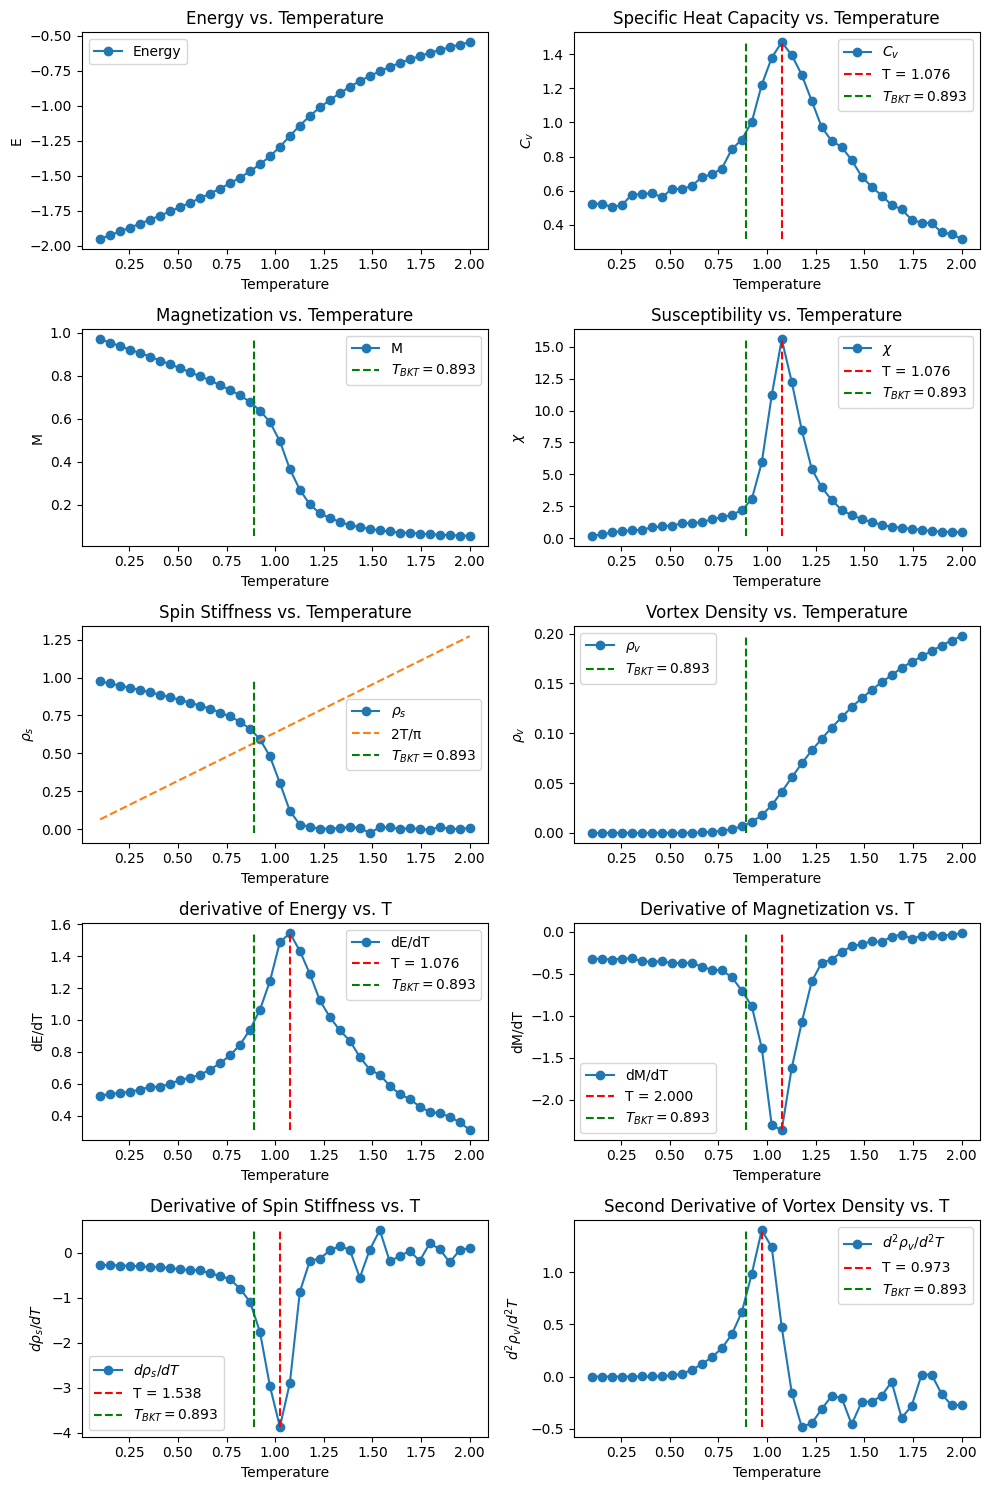

In [17]:
print(f"Samples shape: {samples_xy.shape}")

sampler_xy.spins = samples_xy

energy_xy = sampler_xy.compute_average_energy()
energy_xy_derivative = sampler_xy.high_precision_derivative(
    seq=energy_xy, spacing=precision).cpu().numpy()
energy_xy = energy_xy.cpu().numpy()
capacity_xy = sampler_xy.compute_specific_heat_capacity().cpu().numpy()
stiffness_xy = sampler_xy.compute_spin_stiffness()
stiffness_xy_derivative = sampler_xy.high_precision_derivative(
    seq=stiffness_xy, spacing=precision).cpu().numpy()
stiffness_xy = stiffness_xy.cpu().numpy()
magnetization_xy = sampler_xy.compute_magnetization()
magnetization_xy_derivative = sampler_xy.high_precision_derivative(
    seq=magnetization_xy, spacing=precision).cpu().numpy()
magnetization_xy = magnetization_xy.cpu().numpy()
susceptibility_xy = sampler_xy.compute_susceptibility().cpu().numpy()
vortex_density_xy = sampler_xy.compute_vortex_density()
vortex_density_xy_derivative = sampler_xy.high_precision_derivative(
    seq=vortex_density_xy, spacing=precision)
vortex_density_xy_derivative2 = sampler_xy.high_precision_derivative(
    seq=vortex_density_xy_derivative, spacing=precision).cpu().numpy()
vortex_density_xy = vortex_density_xy.cpu().numpy()
temp = sampler_xy.T.cpu().numpy()

plt.figure(figsize=(10, 15))
plt.subplot(521)
plt.plot(temp, energy_xy, label='Energy', marker='o')
plt.xlabel('Temperature')
plt.ylabel('E')
plt.title('Energy vs. Temperature')
plt.legend()
plt.subplot(522)
plt.plot(temp, capacity_xy, label=r'$C_v$', marker='o')
plt.vlines(temp[capacity_xy.argmax()], capacity_xy.min(), capacity_xy.max(),
           color='red', linestyle='--', label='T = %.3f' % temp[capacity_xy.argmax()])
plt.vlines(0.893, capacity_xy.min(), capacity_xy.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel(r'$C_v$')
plt.title('Specific Heat Capacity vs. Temperature')
plt.legend()
plt.subplot(523)
plt.plot(temp, magnetization_xy, label='M', marker='o')
plt.vlines(0.893, magnetization_xy.min(), magnetization_xy.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel('M')
plt.title('Magnetization vs. Temperature')
plt.legend()
plt.subplot(524)
plt.plot(temp, susceptibility_xy, label=r'$\chi$', marker='o')
plt.vlines(temp[susceptibility_xy.argmax()], susceptibility_xy.min(), susceptibility_xy.max(),
              color='red', linestyle='--', label='T = %.3f' % temp[susceptibility_xy.argmax()])
plt.vlines(0.893, susceptibility_xy.min(), susceptibility_xy.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel(r'$\chi$')
plt.title('Susceptibility vs. Temperature')
plt.legend()
plt.subplot(525)
plt.plot(temp, stiffness_xy, label=r'$\rho_{s}$', marker='o')
plt.plot(temp, list(map(lambda x: 2 * x / torch.pi, temp)), label='2T/π', linestyle='--')
plt.vlines(0.893, stiffness_xy.min(), stiffness_xy.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel(r'$\rho_{s}$')
plt.title('Spin Stiffness vs. Temperature')
plt.legend()
plt.subplot(526)
plt.plot(temp, vortex_density_xy, label=r'$ρ_v$', marker='o')
plt.vlines(0.893, vortex_density_xy.min(), vortex_density_xy.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel(r'$ρ_v$')
plt.title('Vortex Density vs. Temperature')
plt.legend()
plt.subplot(527)
plt.plot(temp, energy_xy_derivative, label='dE/dT', marker='o')
plt.vlines(temp[energy_xy_derivative.argmax()], energy_xy_derivative.min(), energy_xy_derivative.max(),
              color='red', linestyle='--', label='T = %.3f' % temp[energy_xy_derivative.argmax()])
plt.vlines(0.893, energy_xy_derivative.min(), energy_xy_derivative.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel('dE/dT')
plt.title('derivative of Energy vs. T')
plt.legend()
plt.subplot(528)
plt.plot(temp, magnetization_xy_derivative, label='dM/dT', marker='o')
plt.vlines(temp[magnetization_xy_derivative.argmin()], magnetization_xy_derivative.min(), magnetization_xy_derivative.max(),
                color='red', linestyle='--', label='T = %.3f' % temp[magnetization_xy_derivative.argmax()])
plt.vlines(0.893, magnetization_xy_derivative.min(), magnetization_xy_derivative.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel('dM/dT')
plt.title('Derivative of Magnetization vs. T')
plt.legend()
plt.subplot(529)
plt.plot(temp, stiffness_xy_derivative, label=r'$dρ_s/dT$', marker='o')
plt.vlines(temp[stiffness_xy_derivative.argmin()], stiffness_xy_derivative.min(), stiffness_xy_derivative.max(),
                color='red', linestyle='--', label='T = %.3f' % temp[stiffness_xy_derivative.argmax()])
plt.vlines(0.893, stiffness_xy_derivative.min(), stiffness_xy_derivative.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel(r'$dρ_s/dT$')
plt.title('Derivative of Spin Stiffness vs. T')
plt.legend()
plt.subplot(5, 2, 10)
plt.plot(temp, vortex_density_xy_derivative2, label=r'$d^2ρ_v/d^2T$', marker='o')
plt.vlines(temp[vortex_density_xy_derivative2.argmax()], vortex_density_xy_derivative2.min(), vortex_density_xy_derivative2.max(),
                color='red', linestyle='--', label='T = %.3f' % temp[vortex_density_xy_derivative2.argmax()])
plt.vlines(0.893, vortex_density_xy_derivative2.min(), vortex_density_xy_derivative2.max(),
           color='green', linestyle='--', label=r'$T_{BKT} = 0.893$')
plt.xlabel('Temperature')
plt.ylabel(r'$d^2ρ_v/d^2T$')
plt.title('Second Derivative of Vortex Density vs. T')
plt.legend()
plt.tight_layout()
plt.show()
torch.cuda.empty_cache()

In [18]:
del sampler_xy, samples_xy, energy_xy, capacity_xy, stiffness_xy, magnetization_xy, susceptibility_xy, vortex_density_xy,\
    temp, vortex_density_xy_derivative, vortex_density_xy_derivative2, energy_xy_derivative,\
    stiffness_xy_derivative, magnetization_xy_derivative
del n_sweeps, n_therm, decorrelate, pt_interval, pt_prob, tau_pt, tau_eff
del factor_therm, factor_decorrelate, ensemble_number, n_chains, precision, T_start, T_end, L
del device, T
gc.collect()
torch.cuda.empty_cache()

# Ising Model

In [19]:
L = 32 # Lattice size
T_start = 1.0 # Start temperature
T_end = 3.5 # End temperature
precision = 0.05 # Temperature precision
device = "cuda:0"
T = torch.linspace(T_start, T_end, int((T_end-T_start)//precision)+1, device=device)
ensemble_number = 3000 # Number of samples
n_chains = 30 # Number of parallel chains. Suggested: 10~50
factor_therm = 5 # 10~50
factor_decorrelate = 1 # 1~10
tau = L**2 # Autocorrelation time
n_therm =  int(factor_therm * tau) # Number of thermalization sweeps
decorrelate = int(factor_decorrelate * L) # Number of decorrelation sweeps
n_sweeps = int(ensemble_number / n_chains) * decorrelate # Number of sweeps

print(f"Lattice size: {L}")
print(f"Temperature range: {T_start} to {T_end}")
print(f"Number of temperatures: {len(T)}")
print(f"Number of samples per temperature: {ensemble_number}")
print(f"Number of sweeps: {n_sweeps}")
print(f"Number of thermalization sweeps: {n_therm}")
print(f"Number of chains: {n_chains}")
print(f"Number of decorrelate: {decorrelate}")

sampler_ising = IsingModel(
    L=L,
    T=T,
    n_chains=n_chains,
    device=torch.device(device),
    )

start = time.time()
samples_ising = sampler_ising(n_sweeps=n_sweeps, n_therm=n_therm, decorrelate=decorrelate)
end = time.time()
print(f"Elapsed time: {end - start:.2f} s")

Lattice size: 32
Temperature range: 1.0 to 3.5
Number of temperatures: 50
Number of samples per temperature: 3000
Number of sweeps: 3200
Number of thermalization sweeps: 5120
Number of chains: 30
Number of decorrelate: 32
Elapsed time: 20.62 s


Samples shape: torch.Size([50, 3000, 32, 32])


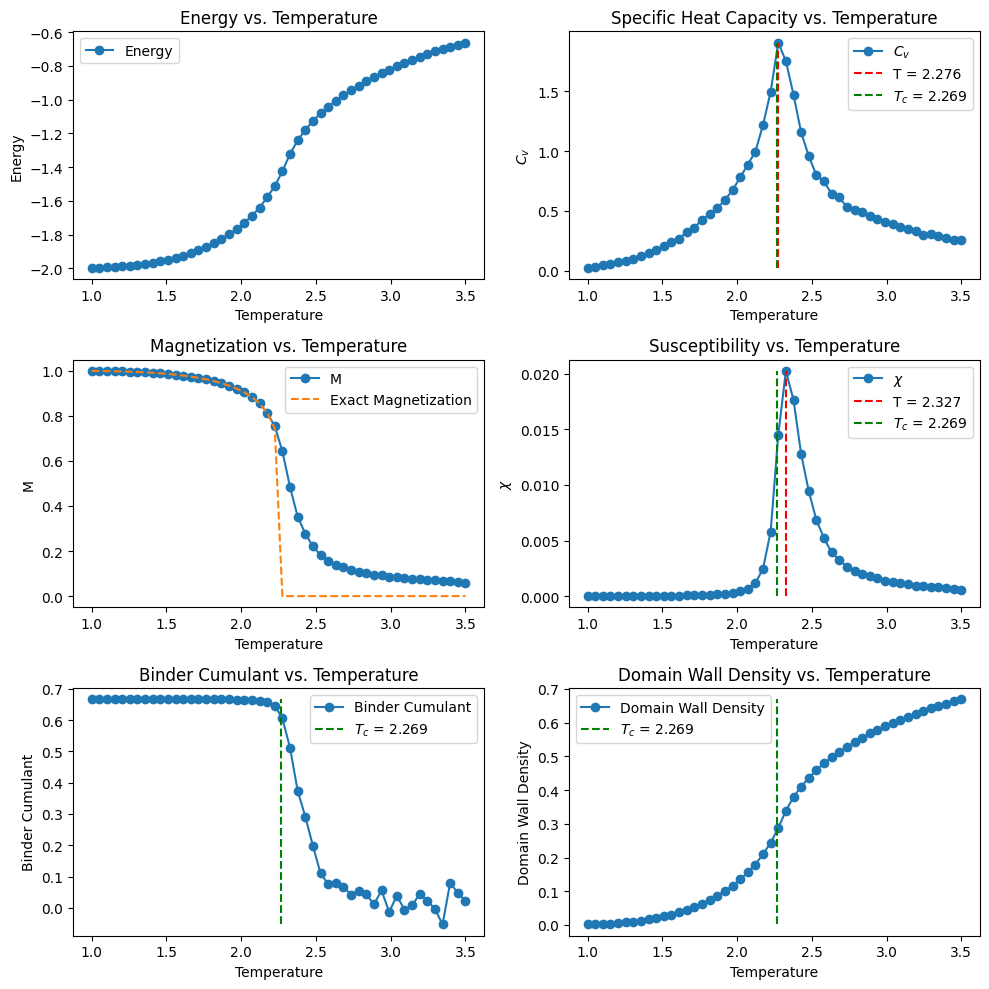

In [20]:
print(f"Samples shape: {samples_ising.shape}")

sampler_ising.spins = samples_ising

energy_ising = sampler_ising.compute_average_energy().cpu().numpy()
capacity_ising = sampler_ising.compute_specific_heat_capacity().cpu().numpy()
magnetization_ising = sampler_ising.compute_magnetization().cpu().numpy()
exact_magnetization_ising = sampler_ising.compute_exact_magnetization().cpu().numpy()
susceptibility_ising = sampler_ising.compute_susceptibility().cpu().numpy()
binder_cumulant_ising = sampler_ising.compute_binder_cumulant().cpu().numpy()
domain_wall_density_ising = sampler_ising.compute_domain_wall_density().cpu().numpy()
temp = sampler_ising.T.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(321)
plt.plot(temp, energy_ising, label='Energy', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.title('Energy vs. Temperature')
plt.legend()
plt.subplot(322)
plt.plot(temp, capacity_ising, label=r'$C_v$', marker='o')
plt.vlines(temp[capacity_ising.argmax()], capacity_ising.min(), capacity_ising.max(),
              color='red', linestyle='--', label='T = %.3f' % temp[capacity_ising.argmax()])
plt.vlines(2.269, capacity_ising.min(), capacity_ising.max(), color='green', linestyle='--', label='$T_c$ = 2.269')
plt.xlabel('Temperature')
plt.ylabel(r'$C_v$')
plt.title('Specific Heat Capacity vs. Temperature')
plt.legend()
plt.subplot(323)
plt.plot(temp, magnetization_ising, label='M', marker='o')
plt.plot(temp, exact_magnetization_ising, label='Exact Magnetization', linestyle='--')
plt.xlabel('Temperature')
plt.ylabel('M')
plt.title('Magnetization vs. Temperature')
plt.legend()
plt.subplot(324)
plt.plot(temp, susceptibility_ising, label=r'$\chi$', marker='o')
plt.vlines(temp[susceptibility_ising.argmax()], susceptibility_ising.min(), susceptibility_ising.max(),
                color='red', linestyle='--', label='T = %.3f' % temp[susceptibility_ising.argmax()])
plt.vlines(2.269, susceptibility_ising.min(), susceptibility_ising.max(), color='green', linestyle='--', label='$T_c$ = 2.269')
plt.xlabel('Temperature')
plt.ylabel(r'$\chi$')
plt.title('Susceptibility vs. Temperature')
plt.legend()
plt.subplot(325)
plt.plot(temp, binder_cumulant_ising, label='Binder Cumulant', marker='o')
plt.vlines(2.269, binder_cumulant_ising.min(), binder_cumulant_ising.max(), color='green', linestyle='--', label='$T_c$ = 2.269')
plt.xlabel('Temperature')
plt.ylabel('Binder Cumulant')
plt.title('Binder Cumulant vs. Temperature')
plt.legend()
plt.subplot(326)
plt.plot(temp, domain_wall_density_ising, label='Domain Wall Density', marker='o')
plt.vlines(2.269, domain_wall_density_ising.min(), domain_wall_density_ising.max(), color='green', linestyle='--', label='$T_c$ = 2.269')
plt.xlabel('Temperature')
plt.ylabel('Domain Wall Density')
plt.title('Domain Wall Density vs. Temperature')
plt.legend()
plt.tight_layout()
plt.show()
torch.cuda.empty_cache()

In [21]:
del sampler_ising, samples_ising, energy_ising, capacity_ising, magnetization_ising, susceptibility_ising, temp,
del n_sweeps, n_therm, decorrelate
del factor_therm, factor_decorrelate, ensemble_number, n_chains, precision, T_start, T_end, L
del device, T
gc.collect()
torch.cuda.empty_cache()

# Potts Model

In [22]:
L = 32 # Lattice size
q = 3 # Number of states in the Potts model
T_start = 0.5 # Start temperature
T_end = 1.5 # End temperature
precision = 0.03 # Temperature precision
device = "cuda:0"
T = torch.linspace(T_start, T_end, int((T_end-T_start)//precision)+1, device=device)
ensemble_number = 3000 # Number of samples
n_chains = 30 # Number of parallel chains. Suggested: 10~50
factor_therm = 5 # 10~50
factor_decorrelate = 1 # 1~10
tau = L**2 # Autocorrelation time
n_therm =  int(factor_therm * tau) # Number of thermalization sweeps
decorrelate = int(factor_decorrelate * L) # Number of decorrelation sweeps
n_sweeps = int(ensemble_number / n_chains) * decorrelate # Number of sweeps

print(f"Lattice size: {L}")
print(f"Number of states: {q}")
print(f"Temperature range: {T_start} to {T_end}")
print(f"Number of temperatures: {len(T)}")
print(f"Number of samples per temperature: {ensemble_number}")
print(f"Number of sweeps: {n_sweeps}")
print(f"Number of thermalization sweeps: {n_therm}")
print(f"Number of chains: {n_chains}")
print(f"Number of decorrelate: {decorrelate}")

sampler_potts = PottsModel(
    L=L,
    T=T,
    q=q,
    n_chains=n_chains,
    device=torch.device(device),
    use_amp=True,
    )

start = time.time()
samples_potts = sampler_potts(n_sweeps=n_sweeps, n_therm=n_therm, decorrelate=decorrelate)
end = time.time()
print(f"Elapsed time: {end - start:.2f} s")

Lattice size: 32
Number of states: 3
Temperature range: 0.5 to 1.5
Number of temperatures: 34
Number of samples per temperature: 3000
Number of sweeps: 3200
Number of thermalization sweeps: 5120
Number of chains: 30
Number of decorrelate: 32
Elapsed time: 22.49 s


Samples shape: torch.Size([34, 3000, 32, 32])


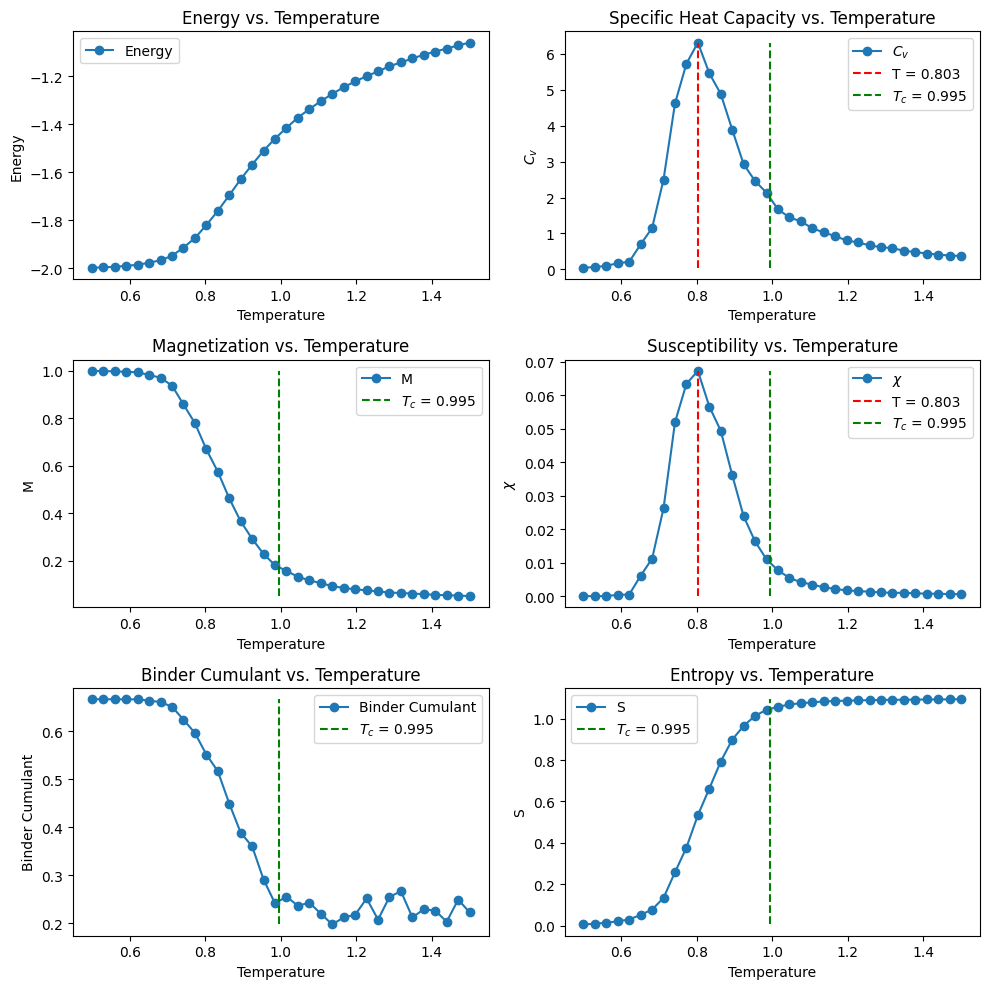

In [23]:
print(f"Samples shape: {samples_potts.shape}")

sampler_potts.spins = samples_potts

energy_potts = sampler_potts.compute_average_energy().cpu().numpy()
capacity_potts = sampler_potts.compute_specific_heat_capacity().cpu().numpy()
magnetization_potts = sampler_potts.compute_magnetization().cpu().numpy()
susceptibility_potts = sampler_potts.compute_susceptibility().cpu().numpy()
binder_cumulant_potts = sampler_potts.compute_binder_cumulant().cpu().numpy()
entropy_potts = sampler_potts.compute_entropy().cpu().numpy()
temp = sampler_potts.T.cpu().numpy()
tc = 1 / torch.log(1 + torch.sqrt(torch.tensor(q)))

plt.figure(figsize=(10, 10))
plt.subplot(321)
plt.plot(temp, energy_potts, label='Energy', marker='o')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.title('Energy vs. Temperature')
plt.legend()
plt.subplot(322)
plt.plot(temp, capacity_potts, label=r'$C_v$', marker='o')
plt.vlines(temp[capacity_potts.argmax()], capacity_potts.min(), capacity_potts.max(),
              color='red', linestyle='--', label='T = %.3f' % temp[capacity_potts.argmax()])
plt.vlines(tc, capacity_potts.min(), capacity_potts.max(), color='green', linestyle='--', label=f'$T_c$ = {tc:.3f}')
plt.xlabel('Temperature')
plt.ylabel(r'$C_v$')
plt.title('Specific Heat Capacity vs. Temperature')
plt.legend()
plt.subplot(323)
plt.plot(temp, magnetization_potts, label='M', marker='o')
plt.vlines(tc, magnetization_potts.min(), magnetization_potts.max(), color='green', linestyle='--', label=f'$T_c$ = {tc:.3f}')
plt.xlabel('Temperature')
plt.ylabel('M')
plt.title('Magnetization vs. Temperature')
plt.legend()
plt.subplot(324)
plt.plot(temp, susceptibility_potts, label=r'$\chi$', marker='o')
plt.vlines(temp[susceptibility_potts.argmax()], susceptibility_potts.min(), susceptibility_potts.max(),
                color='red', linestyle='--', label='T = %.3f' % temp[susceptibility_potts.argmax()])
plt.vlines(tc, susceptibility_potts.min(), susceptibility_potts.max(), color='green', linestyle='--', label=f'$T_c$ = {tc:.3f}')
plt.xlabel('Temperature')
plt.ylabel(r'$\chi$')
plt.title('Susceptibility vs. Temperature')
plt.legend()
plt.subplot(325)
plt.plot(temp, binder_cumulant_potts, label='Binder Cumulant', marker='o')
plt.vlines(tc, binder_cumulant_potts.min(), binder_cumulant_potts.max(), color='green', linestyle='--', label=f'$T_c$ = {tc:.3f}')
plt.xlabel('Temperature')
plt.ylabel('Binder Cumulant')
plt.title('Binder Cumulant vs. Temperature')
plt.legend()
plt.subplot(326)
plt.plot(temp, entropy_potts, label='S', marker='o')
plt.vlines(tc, entropy_potts.min(), entropy_potts.max(), color='green', linestyle='--', label=f'$T_c$ = {tc:.3f}')
plt.xlabel('Temperature')
plt.ylabel('S')
plt.title('Entropy vs. Temperature')
plt.legend()
plt.tight_layout()
plt.show()
torch.cuda.empty_cache()

In [24]:
del sampler_potts, samples_potts, energy_potts, capacity_potts, magnetization_potts, susceptibility_potts, temp,
del n_sweeps, n_therm, decorrelate
del factor_therm, factor_decorrelate, ensemble_number, n_chains, precision, T_start, T_end, L
del device, T
gc.collect()
torch.cuda.empty_cache()